# Custom Albumentations augmentations and Ultralytics as the project's dependency

**Author:** [Andrei Alkhouski](https://github.com/Andredance) ([LinkedIn](https://www.linkedin.com/in/andredance/))

This notebook was created by Andrei Alkhouski, demonstrating how to seamlessly integrate custom Albumentations augmentations into Ultralytics training pipelines without modifying the Ultralytics source code.

---

The example shows how to customize the Ultralytics pipeline with augmentations from the Albumentations library when you have both as  the project's dependencies.

There are at least two ways to customize augmentation inside the Ultralytics pipeline.

1. Ultralytics repository clone and augmentations customization:

Basics are described in Ultralytics docs: [Enhance Your Dataset to Train YOLO11 Using Albumentations](https://docs.ultralytics.com/integrations/albumentations/). You need to download the repository and change the source code of Ultralytics augmentations. More can be found here: [ultralytics.data.augment.Albumentations](https://docs.ultralytics.com/reference/data/augment/?h=albumentation#ultralytics.data.augment.Albumentations)

2. Ultralytics as the project's dependency:

**When**: In case you have Ultralytics as your project dependency and would like to build your own training pipelines.

**Why**: It isn't easy to support a copy of the library that frequently updates its source code. In the case of lot customizations, it's much easier to rely on customizations based on external library API than to face issues with code conflicts later.

We will show an example for the Detection task, but a similar idea is applicable for the Classification task from [Computer vision tasks](https://docs.ultralytics.com/tasks/) (Segment and Pose tasks are not supported yet)

### Install the required libraries

In [ ]:
!pip install albumentationsx ultralytics > /dev/null

### Import the required libraries

## ⚠️ Important: Understanding the Output

During training, you will see **TWO** augmentation-related messages:

1. **DEFAULT MESSAGE** (appears first):
   ```
   albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7))...
   ```
   This is the default Ultralytics initialization message. **This is normal and expected!**

2. **REPLACEMENT MESSAGE** (appears after):
   ```
   ================================================================================
   🔄 REPLACING DEFAULT ULTRALYTICS AUGMENTATIONS
   ================================================================================
   ```
   This confirms that our custom augmentations have successfully replaced the defaults.

**The key is to look for the second message** - it proves your custom augmentations are being used!


In [ ]:
import torch
import albumentations as A

from functools import partial

from ultralytics import YOLO
from ultralytics.data.augment import Albumentations as UltralyticsAlbumentations
from ultralytics.models.yolo.detect.train import DetectionTrainer

# Define custom Albumentations augmentations
To make it work with Albumentations spatial transforms (resizes, etc.), we need to override \_\_call__ implementation:
1. Make sure that class_labels reshaped with (N,1) shape to work correctly with batch concatenation

In [ ]:
class CustomAlbumentations(UltralyticsAlbumentations):
  def __init__(self, transform, contains_spatial: bool, p=1.0):
    super().__init__(p)
    # replace Ultralytics predifined transforms with custom
    self.transform = transform
    self.transform.set_random_seed(torch.initial_seed())
    self.contains_spatial = contains_spatial

    def __call__(self, labels):
        labels = super().__call__(labels)
        if "cls" in labels:
            labels["cls"] = labels["cls"].reshape(-1, 1)
        return labels

  def __repr__(self):
    return str(self.transform)

# Define custom DetectionTrainer
We need to redefine two methods:
1. build_dataset - used by Ultralytics pipeline to prepare the instance of dataset class. Here, we are replacing Ultralytics' Albumentations transforms with our custom transforms.
2. _close_dataloader_mosaic - used to turn off Ultralytics' mosaic augmentation. This leads to a re-creation of the dataset instance, so we need to replace it with our custom augmentations again.

**⚠️ Important Note:** During training initialization, you will see a message showing default Ultralytics augmentations like:
```
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01)...
```
**This is expected!** These defaults are printed during initialization but will be **replaced** by our custom augmentations. Look for the "🔄 REPLACING DEFAULT ULTRALYTICS AUGMENTATIONS" message in the output to confirm your custom augmentations are being applied.

In [ ]:
class CustomTrainer(DetectionTrainer):
    """
    Custom trainer that replaces default Ultralytics augmentations with custom Albumentations.
    
    This trainer intercepts the dataset creation process and replaces the default
    Ultralytics augmentations with our custom Albumentations transforms.
    """
    
    def __init__(self, custom_albumentations_transforms, *args, **kwargs):
        super(CustomTrainer, self).__init__(*args, **kwargs)
        self.custom_albumentations_transforms = custom_albumentations_transforms
        self.replacement_logged = False  # To avoid duplicate logging

    def _close_dataloader_mosaic(self):
        """
        Called when mosaic augmentation is closed (typically at later epochs).
        We need to replace augmentations here too because the dataset gets recreated.
        """
        super()._close_dataloader_mosaic()
        self.__customize_albumentations_transforms(self.train_loader.dataset)

    def __customize_albumentations_transforms(self, dataset):
        """
        Replace default Ultralytics augmentations with our custom ones.
        
        This method iterates through the dataset's transforms and replaces any
        Ultralytics Albumentations instance with our custom one.
        """
        transforms = dataset.transforms.tolist()
        for i, t in enumerate(transforms):
            if isinstance(t, UltralyticsAlbumentations):
                # Log the replacement clearly (only once to avoid spam)
                if not self.replacement_logged:
                    print("\n" + "="*80)
                    print("🔄 REPLACING DEFAULT ULTRALYTICS AUGMENTATIONS")
                    print("="*80)
                    print(f"❌ REMOVING Default Ultralytics augmentations:")
                    print(f"   {t}")
                    print(f"\n✅ APPLYING Custom Albumentations:")
                    print(f"   {self.custom_albumentations_transforms}")
                    print("="*80 + "\n")
                    self.replacement_logged = True
                
                # Replace with custom Albumentations instance
                transforms[i] = self.custom_albumentations_transforms

    def build_dataset(self, img_path, mode="train", batch=None):
        """
        Build dataset and immediately replace augmentations.
        
        This is called during training initialization, so we replace
        augmentations right when the dataset is created.
        """
        dataset = super().build_dataset(img_path, mode=mode, batch=batch)
        self.__customize_albumentations_transforms(dataset)
        return dataset

## Define custom augmentations and train the model

### Example 1: Color Augmentations (Simple)

Let's start with color augmentations that don't affect bounding boxes. We'll use an extreme blur to make the effect obvious and verify our custom augmentations are being applied.

**What will happen:**
1. During initialization, you'll see the default Ultralytics augmentations message
2. Then you'll see our "REPLACING DEFAULT ULTRALYTICS AUGMENTATIONS" message
3. This confirms our custom augmentations are being used instead of the defaults

In [ ]:
# Define custom augmentations with extreme blur for demonstration
# The extreme blur (100, 100) makes it obvious that our augmentations are being applied
transform = A.Compose([
    A.Blur(blur_limit=(100, 100), p=1.0),  # Very strong blur - for demonstration
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
])

# Create our custom augmentations wrapper
custom_albumentations_transforms = CustomAlbumentations(
    transform, 
    contains_spatial=False  # No spatial transforms, so no bbox handling needed
)

print("📋 Custom augmentations we want to apply:")
print(f"   {transform}")
print("\n⚠️ WATCH THE OUTPUT BELOW:")
print("1. First you'll see: 'albumentations: Blur(p=0.01, blur_limit=(3, 7))...' - DEFAULT message")
print("2. Then you'll see: '🔄 REPLACING DEFAULT ULTRALYTICS AUGMENTATIONS' - our REPLACEMENT")
print("3. This confirms our custom augmentations are active!\n")

# Initialize model
model = YOLO("yolov8n.pt")  # Using nano model for faster testing

# Train with custom augmentations
model.train(
    data="coco8.yaml", 
    epochs=2,  # Just 2 epochs for demonstration
    imgsz=640, 
    batch=4,  # Small batch size for testing
    trainer=partial(CustomTrainer, custom_albumentations_transforms=custom_albumentations_transforms),
    device='cpu',  # Use CPU for testing (change to 'cuda' if you have GPU)
    workers=0,  # Disable multiprocessing for clearer output
)

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/opt/homebrew/Caskroom/miniconda/base/envs/albumentations_examples/lib/python3.9/site-packages/albumentations/augmentations/blur/functional.py:232: UserWarning: blur_limit: Non-zero kernel sizes must be odd. Range (100, 100) automatically adjusted to (101, 101).
  result = _ensure_odd_values(result, info.field_name)


📋 Custom augmentations we want to apply:
   Compose([
  Blur(p=1.0, blur_limit=(101, 101)),
  RandomBrightnessContrast(p=0.5, brightness_by_max=True, brightness_limit=(-0.3, 0.3), contrast_limit=(-0.3, 0.3), ensure_safe_range=False),
  HueSaturationValue(p=0.5, hue_shift_limit=(-20.0, 20.0), sat_shift_limit=(-30.0, 30.0), val_shift_limit=(-20.0, 20.0)),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True, seed=0)

⚠️ WATCH THE OUTPUT BELOW:
1. First you'll see: 'albumentations: Blur(p=0.01, blur_limit=(3, 7))...' - DEFAULT message
2. Then you'll see: '🔄 REPLACING DEFAULT ULTRALYTICS AUGMENTATIONS' - our REPLACEMENT
3. This confirms our custom augmentations are active!

Ultralytics 8.3.201 🚀 Python-3.9.21 torch-2.6.0 CPU (Apple M4 Max)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0, 16, 17, 20, 25, 58])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x33dd29700>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

## Batch examples before mosaic close and after

Before mosaic:

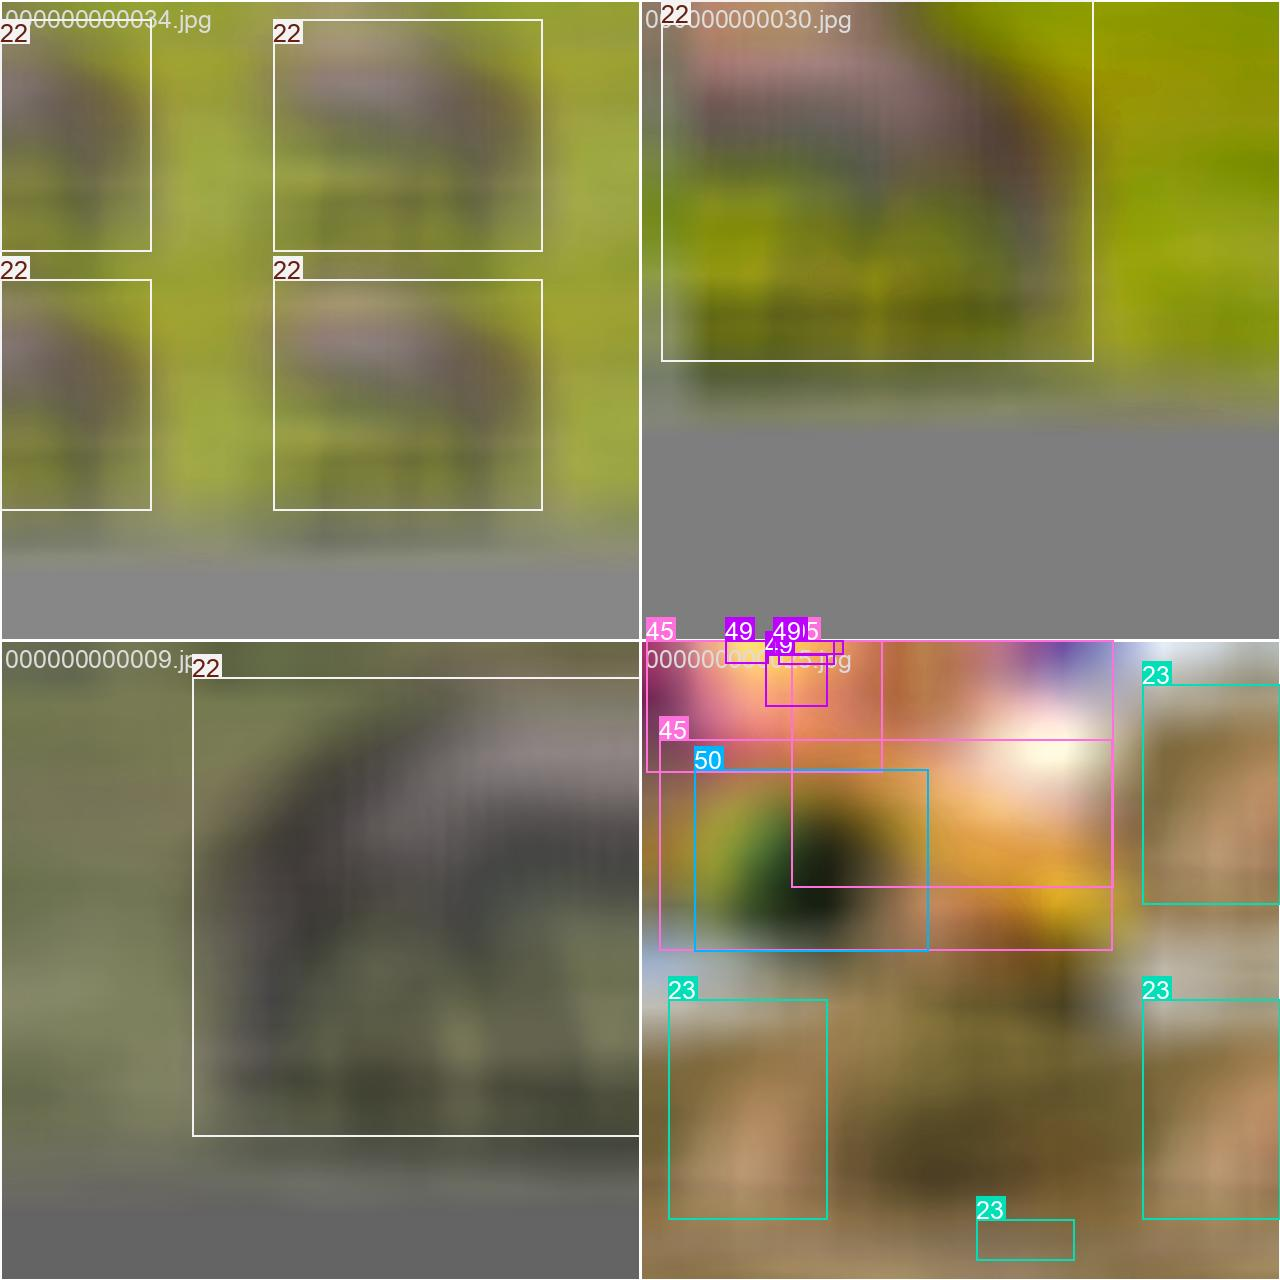

After mosaic:

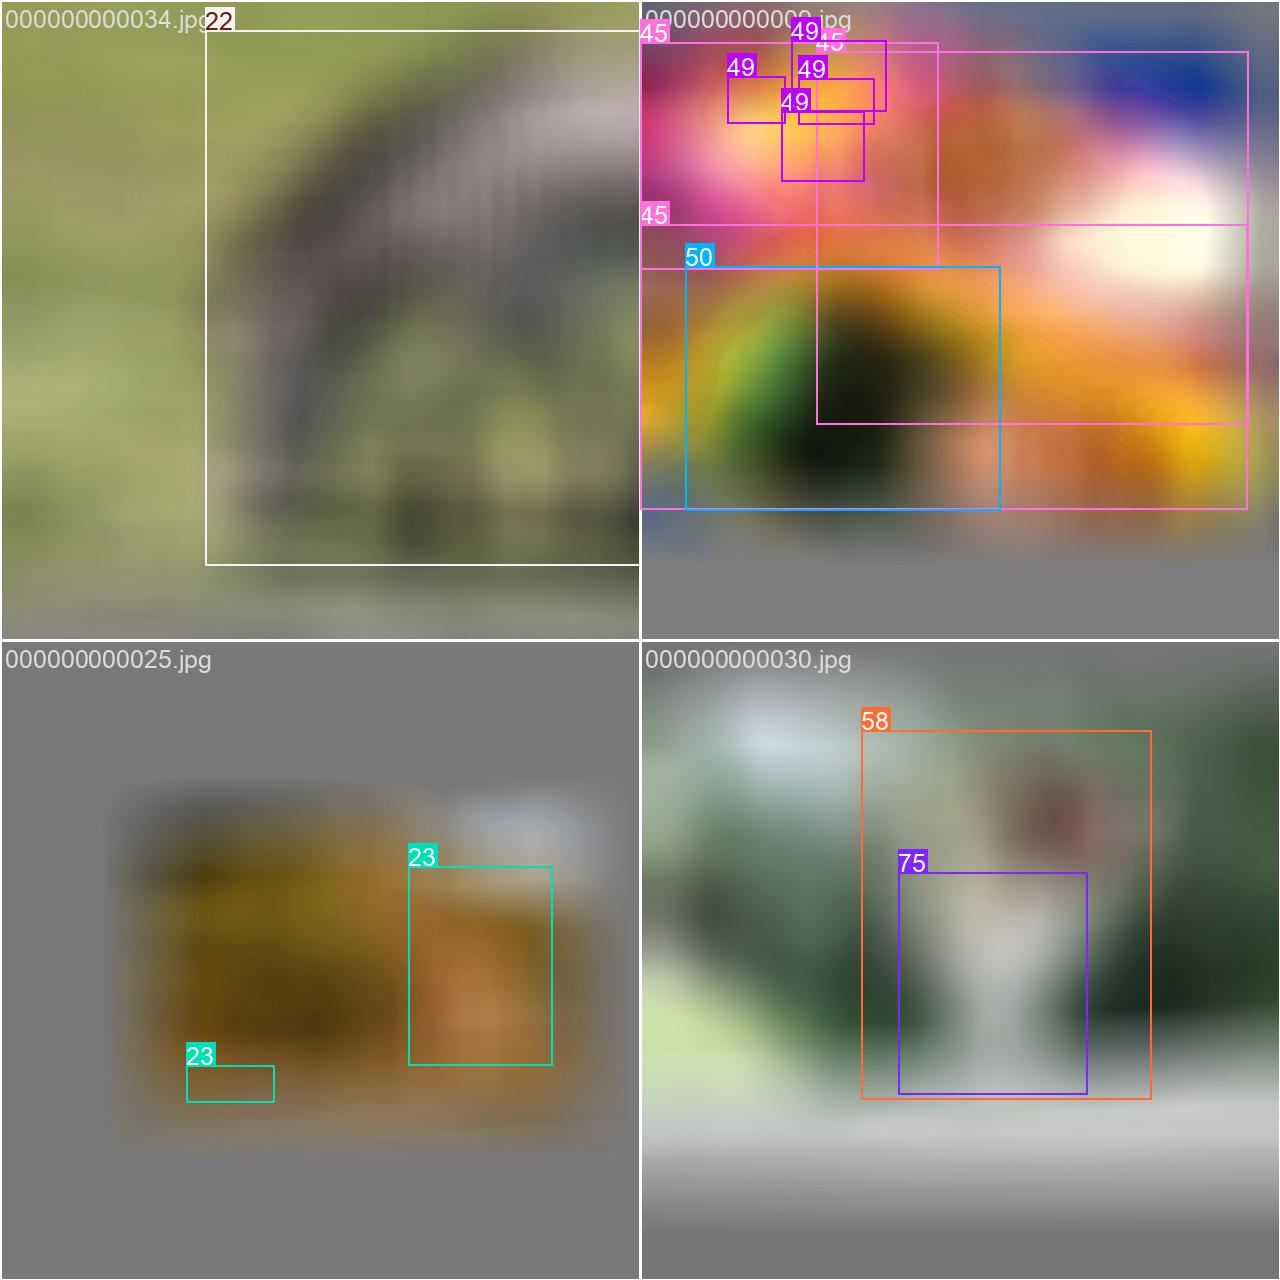

### Example 2: Spatial Augmentations (With Bounding Box Support)

Now let's use spatial transformations that affect bounding boxes. These require special handling to ensure bounding boxes are transformed correctly along with the images.

**Key differences from color augmentations:**
- We add `bbox_params=A.BboxParams(format="yolo", label_fields=["class_labels"])` to handle bounding boxes
- We set `contains_spatial=True` in our CustomAlbumentations
- Some spatial transforms change input image size (like CenterCrop)

**⚠️ Important:** Make sure that custom Albumentations augmentations output the exact image size you specified for training (otherwise, you can face unexpected errors).

**Again, watch for the replacement message to confirm our augmentations are active!**

In [ ]:
# Set the target image size for training
image_size = 640

# Define spatial augmentations with bounding box support
# Note the bbox_params - this is CRUCIAL for spatial transforms!
transform = A.Compose([
    # Spatial transforms that affect bounding boxes
    A.HorizontalFlip(p=0.5),  # 50% chance to flip horizontally
    A.ShiftScaleRotate(
        shift_limit=0.1,   # Shift by up to 10% of image size
        scale_limit=0.2,   # Scale by ±20%
        rotate_limit=30,   # Rotate by up to ±30 degrees
        p=0.7              # Apply this transform 70% of the time
    ),
    
    # Color transforms (don't affect bboxes but enhance augmentation)
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(
        hue_shift_limit=20,
        sat_shift_limit=30, 
        val_shift_limit=20,
        p=0.5
    ),
], bbox_params=A.BboxParams(
    format="yolo",  # YOLO format: [x_center, y_center, width, height] normalized
    label_fields=["class_labels"]  # Field name for class labels
))

# Create custom augmentations wrapper WITH spatial support
custom_albumentations_transforms = CustomAlbumentations(
    transform, 
    contains_spatial=True  # THIS IS TRUE because we have spatial transforms
)

print("📋 Custom SPATIAL augmentations we want to apply:")
for aug in transform.transforms:
    print(f"   • {aug}")
print(f"\n📦 BBox params: YOLO format with label_fields=['class_labels']")

print("\n⚠️ WATCH THE OUTPUT BELOW:")
print("1. First you'll see: 'albumentations: Blur(p=0.01, blur_limit=(3, 7))...' - DEFAULT message")
print("2. Then you'll see: '🔄 REPLACING DEFAULT ULTRALYTICS AUGMENTATIONS' - our REPLACEMENT")
print("3. This confirms our custom SPATIAL augmentations are active!\n")

# Initialize model
model = YOLO("yolov8n.pt")  # Using nano model for faster testing

# Train with custom spatial augmentations
model.train(
    data="coco8.yaml", 
    epochs=2,  # Just 2 epochs for demonstration
    imgsz=image_size,  # Use the defined image size
    batch=4,  # Small batch size for testing
    trainer=partial(CustomTrainer, custom_albumentations_transforms=custom_albumentations_transforms),
    device='cpu',  # Use CPU for testing (change to 'cuda' if you have GPU)
    workers=0,  # Disable multiprocessing for clearer output
)

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/opt/homebrew/Caskroom/miniconda/base/envs/albumentations_examples/lib/python3.9/site-packages/albumentations/core/validation.py:132: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


📋 Custom SPATIAL augmentations we want to apply:
   • HorizontalFlip(p=0.5)
   • ShiftScaleRotate(p=0.7, shift_limit_x=(-0.1, 0.1), shift_limit_y=(-0.1, 0.1), scale_limit=(-0.19999999999999996, 0.19999999999999996), rotate_limit=(-30.0, 30.0), interpolation=1, border_mode=0, fill=0.0, fill_mask=0.0, rotate_method='largest_box', mask_interpolation=0)
   • RandomBrightnessContrast(p=0.5, brightness_by_max=True, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), ensure_safe_range=False)
   • HueSaturationValue(p=0.5, hue_shift_limit=(-20.0, 20.0), sat_shift_limit=(-30.0, 30.0), val_shift_limit=(-20.0, 20.0))

📦 BBox params: YOLO format with label_fields=['class_labels']

⚠️ WATCH THE OUTPUT BELOW:
1. First you'll see: 'albumentations: Blur(p=0.01, blur_limit=(3, 7))...' - DEFAULT message
2. Then you'll see: '🔄 REPLACING DEFAULT ULTRALYTICS AUGMENTATIONS' - our REPLACEMENT
3. This confirms our custom SPATIAL augmentations are active!

Ultralytics 8.3.201 🚀 Python-3.9.21 torch-2.6.0 

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0, 16, 17, 20, 25, 58])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x357c1ee50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

## Summary and Key Takeaways

### What We Demonstrated

1. **Custom Albumentations Integration**: Successfully integrated custom Albumentations augmentations into Ultralytics training pipeline WITHOUT modifying Ultralytics source code.

2. **Two Types of Augmentations**:
   - **Color augmentations** (Blur, Brightness, Contrast, HSV) - simpler, no bbox handling needed
   - **Spatial augmentations** (Flip, Rotate, Scale, Shift) - require bbox_params for proper bounding box transformation

3. **The Replacement Process**:
   - The default Ultralytics message `albumentations: Blur(p=0.01, blur_limit=(3, 7))...` appears during initialization
   - Our custom trainer then replaces these with our custom augmentations
   - The "🔄 REPLACING DEFAULT ULTRALYTICS AUGMENTATIONS" message confirms the replacement

### Key Components

1. **CustomAlbumentations Class**: Wraps Albumentations transforms to work with Ultralytics
2. **CustomTrainer Class**: Intercepts dataset creation to replace default augmentations
3. **functools.partial**: Passes our custom augmentations to the trainer

### Important Notes

- The default augmentation message is **expected** - it's just initialization
- Your custom augmentations **do replace** the defaults - watch for the replacement message
- For spatial transforms, always ensure output size matches your training image size
- Use `contains_spatial=True` and `bbox_params` for spatial transforms

### Credits

This approach was developed by **[Andrei Alkhouski](https://github.com/Andredance)** ([LinkedIn](https://www.linkedin.com/in/andredance/)), demonstrating a clean way to integrate custom augmentations without forking or modifying the Ultralytics library.

---

Feel free to experiment with different augmentations from the [Albumentations library](https://albumentations.ai/docs) to enhance your training!
